# TEST OF Prophet Regressor

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from prophet import Prophet

In [2]:
data = pd.read_parquet('./data/train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


In [3]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

In [4]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [5]:
df_ext = pd.read_csv(Path('submissions') / 'starting_kit' / 'external_data copy.csv')
df_ext.head()

,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,...,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,confi,holiday
0,0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,...,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,...,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN,0,1
3,3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,...,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,...,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN,0,1


You can find the detailed documentation for each feature [in this PDF](https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf) (in French). Here the only feature we consider is the temperature. We will use [pandas.merge_asof](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.merge_asof.html) to merge on date, using the closest available date (since the sampling between the external data and the counter data).

In [9]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data copy.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'u', 'rr24', 'tend24', 'confi']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [10]:
X_train_merge = _merge_external_data(X_train)
columns_merge = X_train_merge.columns
columns_merge

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'counter_technical_id', 'latitude',
       'longitude', 't', 'u', 'rr24', 'tend24', 'confi'],
      dtype='object')

In [11]:
df_y = pd.DataFrame(y_train)
df_y['y'] = df_y.iloc[:, 0]
df_y = df_y.drop([0], axis=1)
X_train_bis = X_train_merge.join(df_y)
X_train_bis

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,t,u,rr24,tend24,confi,y
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,285.75,81,0.0,120.0,0,1.609438
157,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,283.95,88,0.0,0.0,0,1.098612
193,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,283.95,88,0.0,0.0,0,0.000000
769,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,293.65,41,0.0,-260.0,0,2.197225
959,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,292.15,47,0.0,-210.0,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453515,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,293.05,53,0.2,940.0,0,2.079442
453934,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,288.65,79,0.2,680.0,0,0.693147
454316,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,287.15,88,0.2,590.0,0,4.653960
454411,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,289.75,85,0.2,530.0,0,4.997212


Similarly we can wrap this function into a FunctionTranformer to use it in a scikit-learn pipeline. Now let's see whether this additional feature improves the model,

In [21]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numeric_cols = ['t']

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
])

X_train_bis['ds'] = X_train_bis['date']

regressor = Prophet()
regressor.add_regressor('t')
regressor.add_regressor('u')
regressor.add_regressor('confi')

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    regressor
)

result = regressor.fit(X_train_bis)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -21791.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      90        341671    3.7155e-05       3029.93           1           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


TypeError: argument of type 'Prophet' is not iterable

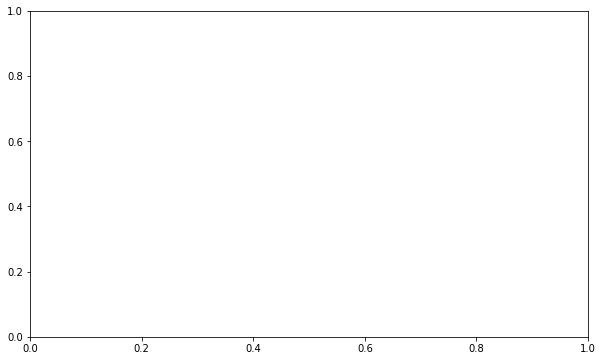

In [27]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(result, metric='mape')